In [47]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm

In [48]:
N = 20 # number of states
replacement_cost = 100 # cost of replacement
transition_probability = np.zeros((2,N,N))
time_steps = 60 # number of time steps

In [49]:
def final_payoff(state):
    return 5*(state**2) - N**2 # final payoff function, negative because it is a cost

def maintenance_cost(state):
    return state**2 + state

def cost_function(state, action, replacement_cost, time):
    if time > time_steps:
        return 0
    if time == time_steps:
        return final_payoff(state)
    if action == 0:
        return replacement_cost + maintenance_cost(0)
    else:
        return maintenance_cost(state)

In [50]:
C = [[[cost_function(i, j, replacement_cost, t) for i in range(N)] for j in range(2)] for t in range(time_steps + 1)]
C = np.array(C)

In [51]:
# Create a meshgrid for plotting
X, Y = np.meshgrid(np.arange(N), np.arange(time_steps + 1))
Z = C[:, 0, :]

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])
fig.update_layout(title='Cost Function Surface For Replacement', scene=dict(
    xaxis_title='State',
    yaxis_title='Time Steps',
    zaxis_title='Cost'
))

fig.show()

In [52]:
X, Y = np.meshgrid(np.arange(N), np.arange(time_steps + 1))
Z = C[:, 1, :]

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])
fig.update_layout(title='Cost Function Surface For Replacement', scene=dict(
    xaxis_title='State',
    yaxis_title='Time Steps',
    zaxis_title='Cost'
))

fig.show()

In [53]:
def fill_transition_probability_matrix(transition_probability, p=0.5):
    for j in range(transition_probability.shape[1]-1):
        transition_probability[1][j][j] = p
        transition_probability[1][j][j+1] = 1-p
    for i in range(transition_probability.shape[1]):
        for j in range(transition_probability.shape[2]):
            transition_probability[0][i][j] = transition_probability[1][0][j]
    transition_probability[1, transition_probability.shape[1]-1, transition_probability.shape[1]-1] = 1

In [54]:
def policy_visualization(policy):
    plt.plot(np.arange(N), policy, marker='o', linestyle='None', markersize=3)
    plt.title("Policy Visualization")
    plt.xlabel("State")
    plt.ylabel("Action")
    plt.show()

In [55]:
fill_transition_probability_matrix(transition_probability=transition_probability, p=0.2)

In [56]:
fig = px.imshow(transition_probability[1], color_continuous_scale='Viridis',
                 labels=dict(x="Next State", y="Current State", color="Transition Probability"),
                 x=np.arange(N), y=np.arange(N))
fig.update_layout(title='Transition Probability Heatmap For Non-Replacement')
fig.show()

In [57]:
fig = px.imshow(transition_probability[0], color_continuous_scale='Viridis',
                 labels=dict(x="Next State", y="Current State", color="Transition Probability"),
                 x=np.arange(N), y=np.arange(N))
fig.update_layout(title='Transition Probability Heatmap For Replacement')
fig.show()

In [62]:
def sarsa(transition_probability, cost_function, time_steps, N, max_episodes=100000, alpha=0.1, gamma=0.9):
    Q = np.zeros((time_steps+1, N, 2))  # Initialize Q-values
    policy = np.zeros((time_steps, N))  # Initialize policy
    epsilon = 1.0

    for episode in tqdm(range(max_episodes)):
        state = 0
        for t in range(time_steps):
            if np.random.rand() < epsilon:
                action = np.random.choice([0, 1])
            else:
                action = np.argmin(Q[t, state])
            next_state = np.random.choice(N, p=transition_probability[action, state])
            reward = cost_function[t, action, state]
            next_action = np.argmin(Q[t+1, next_state]) if t < time_steps - 1 else 0
            Q[t, state, action] += alpha * (reward + gamma * Q[t+1, next_state, next_action] - Q[t, state, action])
            state = next_state

        epsilon = epsilon / (episode+1)
    for t in range(time_steps):
        policy[t] = np.argmin(Q[:, t], axis=1)

    V = np.min(Q, axis=2)
    return V, policy

# Discounted Case

In [63]:
V, policy = sarsa(transition_probability, C, time_steps, N, gamma=0.5)

100%|██████████| 100000/100000 [01:07<00:00, 1488.77it/s]


ValueError: could not broadcast input array from shape (61,) into shape (20,)

In [ ]:
V

array([[ 5.42719479,  5.64155974,  5.12556901, ...,  0.67561716,
         0.        ,  0.        ],
       [ 0.        , 12.72391603, 13.16212479, ...,  4.6980744 ,
         2.        ,  0.        ],
       [ 0.        ,  0.        , 24.32640387, ..., 11.21906411,
         6.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], shape=(20, 61))

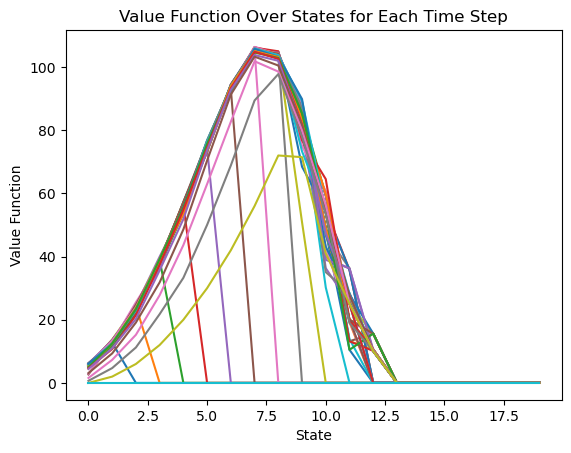

In [ ]:
for t in range(1, time_steps + 1):
    plt.plot(range(N), V[t], label=f'Time step {t}')
plt.xlabel("State")
plt.ylabel("Value Function")
plt.title("Value Function Over States for Each Time Step")
plt.show()

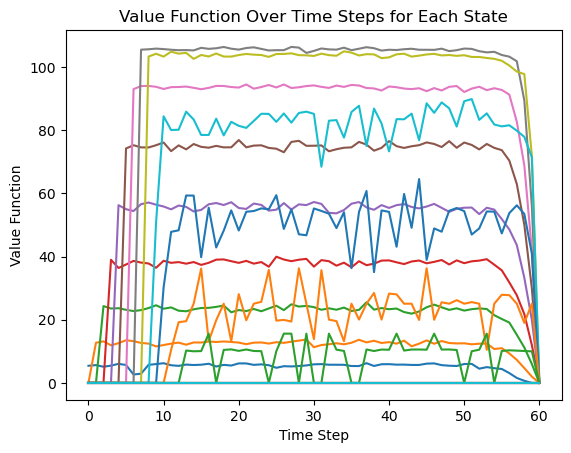

In [ ]:
for s in range(N):
    plt.plot(range(time_steps + 1), V[:, s], label=f'State {s}')
plt.xlabel("Time Step")
plt.ylabel("Value Function")
plt.title("Value Function Over Time Steps for Each State")
plt.show()

In [ ]:
# check if policy remains threshold type throughout time
flag = True
for t in range(time_steps):
    if np.any(policy[t] == 0):
        threshold_state = np.min(np.where(policy[t] == 0))
    else:
        threshold_state = N
    for s in range(threshold_state, N):
        if policy[t, s] != 0:
            flag = False
            break
if flag:
    print("The policy remains threshold type throughout.")
else :
    print("The policy does not remain threshold type throughout.")

The policy does not remain threshold type throughout.


In [ ]:
# mesh plot of value function
X, Y = np.meshgrid(range(N), range(time_steps + 1))
Z = V

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])
fig.update_layout(title='Value Function Surface Plot', scene=dict(
    xaxis_title='State',
    yaxis_title='Time Step',
    zaxis_title='Value Function'))
fig.show()

Note: The values are similar even upto time step 60 but at time: time_steps there is a sudden change, this is because the higher valued states at time: time_steps are never reached due to the replacement action by the higher valued states in the previous time steps

In [ ]:
# mesh plot of policy
Z_policy = policy

fig_policy = go.Figure(data=[go.Surface(z=Z_policy, x=X, y=Y)])
fig_policy.update_layout(title='Policy Surface Plot', scene=dict(
    xaxis_title='State',
    yaxis_title='Time Step',
    zaxis_title='Action'))
fig_policy.show()

# Undiscounted Case

In [ ]:
V, policy = sarsa(transition_probability, C, time_steps, N, gamma=1.0)

100%|██████████| 100000/100000 [01:29<00:00, 1116.65it/s]


ValueError: x and y must have same first dimension, but have shapes (20,) and (61, 20)

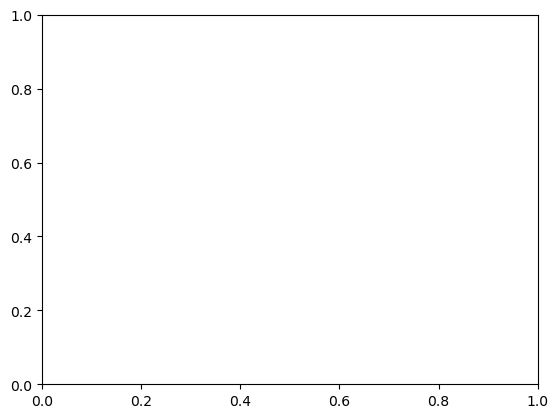

In [ ]:
plt.plot(range(N), V[:time_steps+1, :].T)
plt.xlabel("State")
plt.ylabel("Value Function")
plt.title("Value Function Over States for Each Time Step")
plt.show()

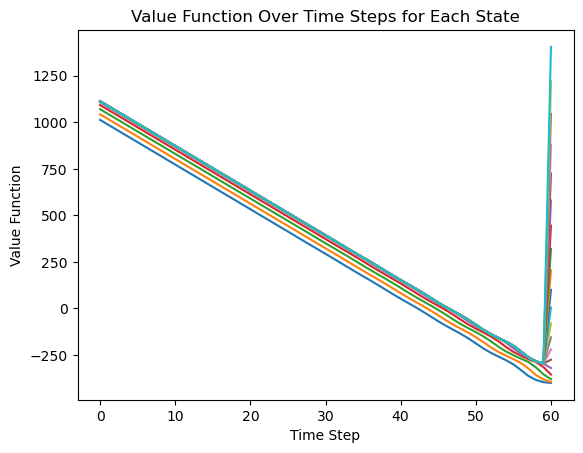

In [ ]:
plt.plot(range(time_steps + 1), V[:, :])
plt.xlabel("Time Step")
plt.ylabel("Value Function")
plt.title("Value Function Over Time Steps for Each State")
plt.show()

In [ ]:
# check if policy remains threshold type throughout time
flag = True
for t in range(time_steps):
    if np.any(policy[t] == 0):
        threshold_state = np.min(np.where(policy[t] == 0))
    else:
        threshold_state = N
    for s in range(threshold_state, N):
        if policy[t, s] != 0:
            flag = False
            break
if flag:
    print("The policy remains threshold type throughout.")

The policy remains threshold type throughout.


In [ ]:
# mesh plot of value function
X, Y = np.meshgrid(range(N), range(time_steps + 1))
Z = V

fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z)])
fig.update_layout(title='Value Function Surface Plot', scene=dict(
    xaxis_title='State',
    yaxis_title='Time Step',
    zaxis_title='Value Function',
    yaxis=dict(range=[0,time_steps + 1])
    ))
fig.show()

Note: The values are similar even upto time step 60 but at time: time_steps there is a sudden change, this is because the higher valued states at time: time_steps are never reached due to the replacement action by the higher valued states in the previous time steps

In [ ]:
# policy over time as  a mesh plot
Z_policy = policy
Z_policy[-1] = np.zeros(N)  # Set the last column to 0 for better visualization

fig_policy = go.Figure(data=[go.Surface(z=Z_policy, x=X, y=Y)])
fig_policy.update_layout(title='Policy Surface Plot', scene=dict(
    xaxis_title='State',
    yaxis_title='Time Step',
    zaxis_title='Action'))
fig_policy.show()

# Modified Policy Iteration Implementation for time dependant policy

In [ ]:
def evaluate_policy(policy, C, P, V, threshold = 0.01, max_iter=100, alpha=0.5):
    for _ in range(max_iter):
        V_new = np.zeros_like(V)
        V_new[time_steps] =  C[time_steps][0]  # Initialize with final costs
        for t in range(time_steps - 1, -1, -1):
            P_pi = np.array([P[int(policy[t][i])][i] for i in range(N)])
            R_pi = np.array([C[t][int(policy[t][i])][i] for i in range(N)])
            V_new[t] = T(R_pi,P_pi,V[t+1], alpha)
        if np.linalg.norm(V_new-V, np.inf) < threshold:
            return V_new
        V = V_new
    return V

In [ ]:
def improve_policy_greedy(C, P, V, alpha=0.5):
    new_policy = np.zeros((time_steps+1, N))
    for t in range(time_steps):
        Q = T(C[t], P, V[t + 1], alpha)
        new_policy[t] = np.argmin(Q, axis=0)
    return new_policy

In [ ]:
def modified_policy_iteration(C, P, max_evaluation_iter=100, max_iter=100, epsilon=0.01, alpha=0.5):
    V = np.zeros((time_steps+1, N))
    policy = np.zeros((time_steps+1, N))
    V[time_steps] = np.array(C[time_steps][0])
    for _ in range(max_iter):
        V_new = evaluate_policy(policy, C, P, V, max_iter=max_evaluation_iter, alpha=alpha)
        policy = improve_policy_greedy(C, P, V_new, alpha=alpha)
        if np.linalg.norm(V_new-V, np.inf) < epsilon:
            return policy, V
        V = V_new
    return policy, V

In [ ]:
policy, V = modified_policy_iteration(C, transition_probability, max_iter=100, alpha=1.0, max_evaluation_iter=1)

In [ ]:
# check if policy remains threshold type throughout time
flag = True
for t in range(time_steps):
    if np.any(policy[t] == 0):
        threshold_state = np.min(np.where(policy[t] == 0))
    else:
        threshold_state = N
    for s in range(threshold_state, N):
        if policy[t, s] != 0:
            flag = False
            break
if flag:
    print("The policy remains threshold type throughout.")
else:
    print("Threshold type policy is not maintained")

The policy remains threshold type throughout.


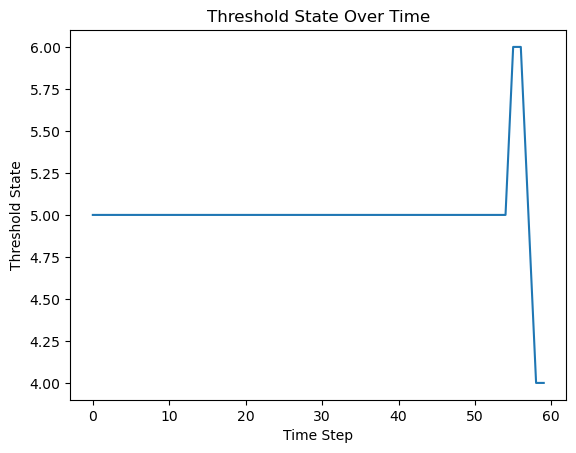

In [ ]:
# plot of threshold over time
thresholds = np.zeros(time_steps)
for t in range(time_steps):
    thresholds[t] = np.min(np.where(policy[t] == 0)) if np.any(policy[t] == 0) else N
plt.plot(range(time_steps), thresholds)
plt.xlabel("Time Step")
plt.ylabel("Threshold State")
plt.title("Threshold State Over Time")
plt.show()

In [ ]:
# mesh plot of value function
X, Y = np.meshgrid(range(N), range(time_steps + 1))
Z = V

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])
fig.update_layout(title='Value Function Surface Plot', scene=dict(
    xaxis_title='State',
    yaxis_title='Time Step',
    zaxis_title='Value Function'))
fig.show()

In [ ]:
# policy over time as  a mesh plot
Z_policy = policy

fig_policy = go.Figure(data=[go.Surface(z=Z_policy, x=X, y=Y)])
fig_policy.update_layout(title='Policy Surface Plot', scene=dict(
    xaxis_title='State',
    yaxis_title='Time Step',
    zaxis_title='Action'))
fig_policy.show()

## Observations:
- Interesting policies when discount factor is small(<0.6) with fluctuating thresholds at the last few steps
- For the highly discounted case(discount factor > 0.6) the policy is intuitive, higher states always replace, lower ones refrain with a few of the lower states replacing at the last time step to get a better payout